In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [151]:
def create_covar_matrix(study_df,std_rise,Lx,dose_index=1):
    Nx_s = study_df["subjects"].to_numpy().astype(np.float64)
    Lx_s = study_df[Lx].to_numpy().astype(np.float64)[dose_index:]
    M1x_s = np.sum(study_df["cases"].to_numpy().astype(np.float64))
    A0_s = M1x_s*Nx_s[1:]/(Nx_s.sum())

    it_fit_ex = IF(Lx_s,A0_s,Nx_s,M1x_s)
    A_s, B_s, a0_s, b0_s = it_fit_ex.convexProgram()

    # C = covariance_matrix(A_s,B_s,a0_s,b0_s,std_rise**2)
    # inv_C = np.linalg.inv(C)

    return A_s, B_s, a0_s, b0_s

In [152]:
# Reading in data
study_df = pd.read_excel("SBPvPAD_data.xlsx")

# Taking care of non-log values in dataframe
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[5,5:8] = np.log(study_df.iloc[5,5:8].to_numpy().astype(np.float64))

# Creating Itoga-specific dataframe
study_df_i = study_df.loc[study_df["Author"] == "Itoga"]
study_df_i_bref = study_df_i.iloc[[0]]
study_df_i_aref = study_df_i.iloc[1:]
study_df_i = pd.concat([study_df_i_aref,study_df_i_bref],ignore_index=True)
# study_df_i = study_df_i.iloc[1:,:]

# Create exposure levels relative to reference exposure
x_i = study_df_i["dose"].to_numpy()[1:] - study_df_i["dose"].to_numpy()[0]

# Get log-odds and corresponding variance estimates
L_i = study_df_i["logOR"].to_numpy()[1:]
v_i = study_df_i["std_error"].to_numpy()[1:]

In [153]:
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
1,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
2,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
3,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
4,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929
5,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879


Regular regression estimates

In [155]:
# Generating covariance matrix and inverse
Ax, Bx, a0x, b0x = create_covar_matrix(study_df_i, v_i, "logOR")

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [165]:
n = Ax.shape[0]
s = np.sqrt(1/Ax + 1/Bx + 1/a0x + 1/b0x)
r = ((1/np.outer(s,s))*(1/a0x + 1/b0x))[np.triu_indices(n,k=1)]
c = r*np.sqrt((np.outer(v_i,v_i))[np.triu_indices(n,k=1)])
# C1 = np.diag(v_i)
triu_indices = np.triu_indices(n,k=1)
# tril_indices = np.tril_indices(n,k=-1)
C2 = np.zeros((n,n))
C2[triu_indices] = c
C = C2 + C2.T
C += np.diag(v_i)

In [161]:
((1/np.outer(s,s))*(1/a0x + 1/b0x))

array([[0.66566743, 0.7182391 , 0.71355507, 0.65733105, 0.44634388],
       [0.7182391 , 0.77496266, 0.76990871, 0.70924434, 0.48159428],
       [0.71355507, 0.76990871, 0.76488771, 0.70461897, 0.47845354],
       [0.65733105, 0.70924434, 0.70461897, 0.64909906, 0.44075416],
       [0.44634388, 0.48159428, 0.47845354, 0.44075416, 0.29928286]])

In [162]:
r

array([0.7182391 , 0.71355507, 0.65733105, 0.44634388, 0.76990871,
       0.70924434, 0.48159428, 0.70461897, 0.47845354, 0.44075416])

In [163]:
c

array([0.02500009, 0.02784281, 0.0243902 , 0.01555686, 0.03260534,
       0.02856215, 0.01821787, 0.03180992, 0.0202894 , 0.01777343])

In [ ]:
V = np.diag(v_i**2)

In [168]:
# C = (Cr - V)/2 + V
inv_C = np.linalg.inv(C)

In [146]:
C

array([[0.00102853, 0.00043509, 0.00054321, 0.0004525 , 0.00027111],
       [0.00043509, 0.00142716, 0.00069041, 0.00057512, 0.00034458],
       [0.00054321, 0.0004525 , 0.00225385, 0.00071803, 0.0004302 ],
       [0.00027111, 0.00069041, 0.00057512, 0.00184292, 0.00035836],
       [0.00034458, 0.00071803, 0.0004302 , 0.00035836, 0.0014348 ]])

In [150]:
Cr - Cr.T

array([[ 0.        ,  0.        ,  0.        ,  0.00036278, -0.00014693],
       [ 0.        ,  0.        ,  0.00047583, -0.00023059, -0.0007469 ],
       [ 0.        , -0.00047583,  0.        ,  0.00028582,  0.        ],
       [-0.00036278,  0.00023059, -0.00028582,  0.        ,  0.        ],
       [ 0.00014693,  0.0007469 ,  0.        ,  0.        ,  0.        ]])

In [149]:
d = 1/np.diag(Cr)
np.diag(np.sqrt(d))@Cr@np.diag(np.sqrt(d))

array([[1.        , 0.7182391 , 0.71355507, 0.65733105, 0.44634388],
       [0.7182391 , 1.        , 0.76990871, 0.70924434, 0.48159428],
       [0.71355507, 0.50460011, 1.        , 0.70461897, 0.47845354],
       [0.39383283, 0.85142846, 0.56437741, 1.        , 0.44075416],
       [0.5672953 , 1.00354824, 0.47845354, 0.44075416, 1.        ]])

In [169]:
# Itoga corrected estimates
vb_star = 1/(np.dot(x_i,np.dot(inv_C,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_C,L_i)))

In [170]:
b_star

0.0039781308721906295

In [171]:
# Itoga unadjusted estimates
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(V),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(V),L_i)))

In [172]:
b

0.004898756562797416

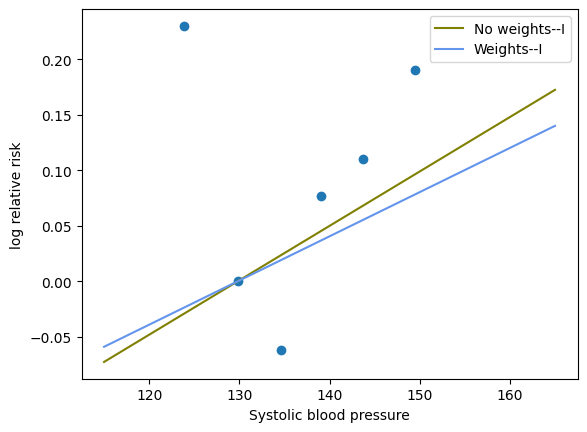

In [173]:
def slope_fn(beta,x):
    return beta*(x-129.8)

x = np.linspace(115,165)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive")
plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.scatter(study_df_i["dose"],study_df_i["logOR"])
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

Quadratic regression

In [174]:
x_2 = x_i**2

In [175]:
X = np.hstack((np.array([x_2]).T,np.array([x_i]).T))

In [176]:
V = np.diag(v_i**2)

In [177]:
theta_vanilla = np.linalg.inv(X.T@np.linalg.inv(V)@X)@X.T@np.linalg.inv(V)@L_i

In [178]:
theta_vanilla

array([ 0.00150758, -0.01702516])

In [179]:
theta_adjusted = np.linalg.inv(X.T@inv_C@X)@X.T@inv_C@L_i

In [180]:
theta_adjusted

array([ 0.00120836, -0.01569159])

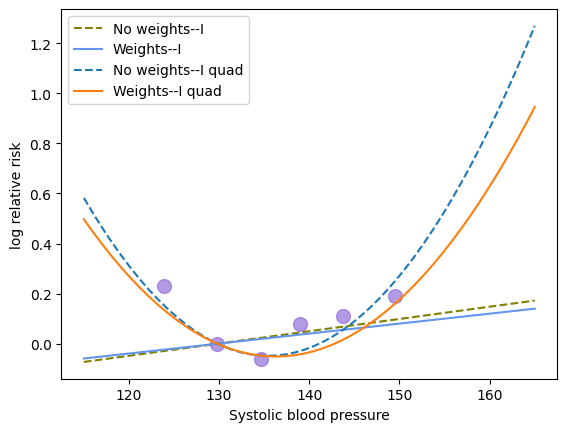

In [181]:
def quad_fn(theta,x):
    return theta[0]*(x-129.8)**2 + theta[1]*(x-129.8)

# x = np.linspace(115,165)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive",linestyle="dashed")
plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.plot(x,quad_fn(theta_vanilla,x),label="No weights--I quad", linestyle="dashed")
plt.plot(x,quad_fn(theta_adjusted,x),label="Weights--I quad")
plt.scatter(study_df_i["dose"],study_df_i["logOR"],s=100,c="mediumpurple",alpha=0.7)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

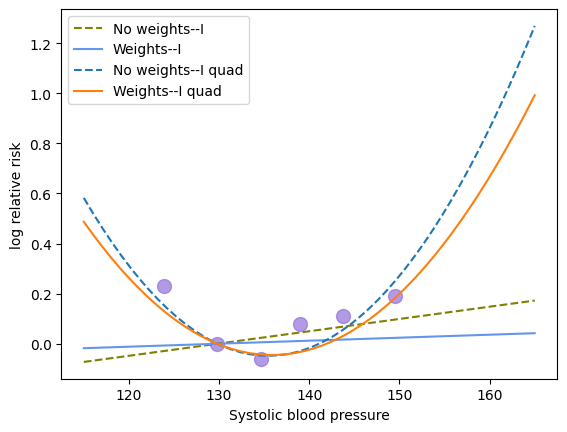

In [145]:
def quad_fn(theta,x):
    return theta[0]*(x-129.8)**2 + theta[1]*(x-129.8)

# x = np.linspace(115,165)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# # plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive",linestyle="dashed")
plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.plot(x,quad_fn(theta_vanilla,x),label="No weights--I quad", linestyle="dashed")
plt.plot(x,quad_fn(theta_adjusted,x),label="Weights--I quad")
plt.scatter(study_df_i["dose"],study_df_i["logOR"],s=100,c="mediumpurple",alpha=0.7)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

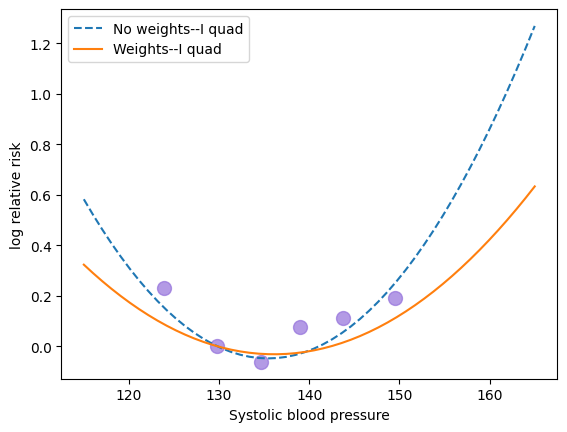

In [130]:
# plt.plot(x,slope_fn(b,x),label="No weights--I",c="olive",linestyle="dashed")
# plt.plot(x,slope_fn(b_star,x),label="Weights--I",c="cornflowerblue")
plt.plot(x,quad_fn(theta_vanilla,x),label="No weights--I quad", linestyle="dashed")
plt.plot(x,quad_fn(theta_adjusted,x),label="Weights--I quad")
plt.scatter(study_df_i["dose"],study_df_i["logOR"],s=100,c="mediumpurple",alpha=0.7)
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()